* Open Xband nc file 
* Compute divergence at every time step throughout the hour
* identify front (max div magnitude?)
* plot lines with time to compute the speed 

From Warner et al. (2018): In 2014, the shipboard X-band (~3 cm) radar was tuned to detect Bragg scattering off of surface ripples that form at convergences, thereby allowing the front orientation and propagation velocity to be mapped over a 5-km radius (Fig. 7).

https://journals.ametsoc.org/view/journals/phoc/48/2/jpo-d-17-0144.1.xml

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
from sklearn.decomposition import PCA
from geopy.distance import geodesic
from scipy.interpolate import griddata
import imageio.v2 as imageio
import tempfile
import os

In [2]:
ds = xr.open_dataset('/Volumes/external/MOTIVE/xband/skq_2024-11-14-14_currents.nc')
# ~0.63 seconds between samples

u = ds.eastward_sea_water_velocity
v = ds.northward_sea_water_velocity
lat = ds.latitude
lon = ds.longitude
time = ds.time

# all have shape 5736

# Convert time and define bins
time = pd.to_datetime(time)
time_bins = pd.date_range(time.min(), time.max(), freq='0.1min')

# Set up grid
lon_lin = np.linspace(lon.min(), lon.max(), 100)
lat_lin = np.linspace(lat.min(), lat.max(), 100)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)

# Store frame file paths for GIF
image_files = []

# Temporary directory for frames
with tempfile.TemporaryDirectory() as tmpdir:
    for i in range(len(time_bins) - 1):
        t0, t1 = time_bins[i], time_bins[i+1]
        mask = (time >= t0) & (time < t1)
        
        if np.sum(mask) < 100:
            continue

        u_bin, v_bin = u[mask], v[mask]
        lon_bin, lat_bin = lon[mask], lat[mask]

        u_grid = griddata((lon_bin, lat_bin), u_bin, (lon_grid, lat_grid), method='linear')
        v_grid = griddata((lon_bin, lat_bin), v_bin, (lon_grid, lat_grid), method='linear')

        dx = np.mean(np.diff(lon_lin)) * 111e3 * np.cos(np.deg2rad(np.mean(lat_lin)))
        dy = np.mean(np.diff(lat_lin)) * 111e3

        dudx = np.gradient(u_grid, dx, axis=1)
        dvdy = np.gradient(v_grid, dy, axis=0)
        divergence = dudx + dvdy

        dvdx = np.gradient(v_grid, dx, axis=1)
        dudy = np.gradient(u_grid, dy, axis=0)
        vorticity = dvdx - dudy

        convergence_mask = vorticity > np.percentile(vorticity[~np.isnan(vorticity)], 95)
        y_idx, x_idx = np.where(convergence_mask)
        if len(x_idx) < 5:
            continue

        front_lons = lon_grid[y_idx, x_idx]
        front_lats = lat_grid[y_idx, x_idx]
        X = np.vstack((front_lons, front_lats)).T
        pca = PCA(n_components=2).fit(X)
        centroid = pca.mean_
        direction = pca.components_[0]

        # Plot frame
        fig, ax = plt.subplots(figsize=(8, 6))
        pcm = ax.pcolormesh(lon_grid, lat_grid, vorticity, vmin=-0.001, vmax=0.001, cmap='RdBu_r', shading='auto')
        ax.contour(lon_grid, lat_grid, convergence_mask, levels=[0.5], colors='yellow', linewidths=1)
        ax.plot(centroid[0], centroid[1], 'mo', label='Front Centroid')

        scale = 0.01
        line = np.array([centroid - scale * direction, centroid + scale * direction])
        ax.plot(line[:, 0], line[:, 1], 'm-', lw=2, label='Front Orientation')

        q = ax.quiver(lon_grid[::5, ::5], lat_grid[::5, ::5],
                      u_grid[::5, ::5], v_grid[::5, ::5],
                      scale=10, color='black', alpha=0.5)
        ax.quiverkey(q, 0.9, 1.03, 0.5, '0.5 m/s', labelpos='E')

        ax.set_title(f"Front Detection: {t0.strftime('%Y-%m-%d %H:%M:%S')}")
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        fig.colorbar(pcm, ax=ax, label='Vorticity [1/s]')
        ax.legend()
        plt.tight_layout()

        # Save frame to temp file
        frame_path = os.path.join(tmpdir, f'frame_{i:04d}.png')
        plt.savefig(frame_path, dpi=100)
        image_files.append(frame_path)
        plt.close()

    # Write GIF
    gif_path = f"/Volumes/external/MOTIVE/xband/gifs/vorticity/vorticity_{t0.strftime('%Y-%m-%d-%HZ')}.gif"
    with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
        for file in image_files:
            writer.append_data(imageio.imread(file))

print(f"✅ GIF saved to {gif_path}")


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/vorticity/vorticity_2024-11-14-14Z.gif


In [130]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import griddata
import imageio
import os
import tempfile
from glob import glob

input_dir = '/Volumes/external/MOTIVE/xband/'
output_dir = os.path.join(input_dir, 'gifs/divergence')
os.makedirs(output_dir, exist_ok=True)

nc_files = sorted(glob(os.path.join(input_dir, '*.nc')))

for nc_file in nc_files:
    try:
        ds = xr.open_dataset(nc_file)
        u = ds.eastward_sea_water_velocity
        v = ds.northward_sea_water_velocity
        lat = ds.latitude
        lon = ds.longitude
        time = pd.to_datetime(ds.time.values)

        # Bin time
        time_bins = pd.date_range(time.min(), time.max(), freq='0.1min')
        lon_lin = np.linspace(lon.min(), lon.max(), 100)
        lat_lin = np.linspace(lat.min(), lat.max(), 100)
        lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)

        image_files = []
        with tempfile.TemporaryDirectory() as tmpdir:
            for i in range(len(time_bins) - 1):
                t0, t1 = time_bins[i], time_bins[i+1]
                mask = (time >= t0) & (time < t1)

                if np.sum(mask) < 100:
                    continue

                u_bin = u[mask].values.flatten()
                v_bin = v[mask].values.flatten()
                lon_bin = lon[mask].values.flatten()
                lat_bin = lat[mask].values.flatten()

                u_grid = griddata((lon_bin, lat_bin), u_bin, (lon_grid, lat_grid), method='linear')
                v_grid = griddata((lon_bin, lat_bin), v_bin, (lon_grid, lat_grid), method='linear')

                dx = np.mean(np.diff(lon_lin)) * 111e3 * np.cos(np.deg2rad(np.mean(lat_lin)))
                dy = np.mean(np.diff(lat_lin)) * 111e3

                dudx = np.gradient(u_grid, dx, axis=1)
                dvdy = np.gradient(v_grid, dy, axis=0)
                divergence = dudx + dvdy

                dvdx = np.gradient(v_grid, dx, axis=1)
                dudy = np.gradient(u_grid, dy, axis=0)
                vorticity = dvdx - dudy

                convergence_mask = divergence < -1e-4#np.nanpercentile(divergence, 5)
                y_idx, x_idx = np.where(convergence_mask)
                if len(x_idx) < 5:
                    continue

                front_lons = lon_grid[y_idx, x_idx]
                front_lats = lat_grid[y_idx, x_idx]
                X = np.vstack((front_lons, front_lats)).T
                pca = PCA(n_components=2).fit(X)
                centroid = pca.mean_
                direction = pca.components_[0]

                # Plot frame
                fig, ax = plt.subplots(figsize=(8, 6))
                pcm = ax.pcolormesh(lon_grid, lat_grid, divergence, cmap='RdBu_r', shading='auto')
                ax.contour(lon_grid, lat_grid, convergence_mask, levels=[0.5], colors='yellow', linewidths=1)
                ax.plot(centroid[0], centroid[1], 'mo', label='Front Centroid')

                scale = 0.01
                line = np.array([centroid - scale * direction, centroid + scale * direction])
                ax.plot(line[:, 0], line[:, 1], 'm-', lw=2, label='Front Orientation')

                q = ax.quiver(lon_grid[::5, ::5], lat_grid[::5, ::5],
                              u_grid[::5, ::5], v_grid[::5, ::5],
                              scale=2, color='black', alpha=0.5)
                ax.quiverkey(q, 0.9, 1.03, 0.5, '0.5 m/s', labelpos='E')

                ax.set_title(f"Front Detection: {t0.strftime('%Y-%m-%d %H:%M:%S')}")
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                fig.colorbar(pcm, ax=ax, label='Vorticity [1/s]')
                ax.legend()
                plt.tight_layout()

                frame_path = os.path.join(tmpdir, f'frame_{i:04d}.png')
                plt.savefig(frame_path, dpi=100)
                image_files.append(frame_path)
                plt.close()

            if image_files:
                file_time = pd.to_datetime(ds.time.values[0])
                gif_name = f'divergence_{file_time.strftime("%Y-%m-%d-%HZ")}.gif'
                gif_path = os.path.join(output_dir, gif_name)
                with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
                    for file in image_files:
                        writer.append_data(imageio.imread(file))
                print(f"✅ GIF saved to {gif_path}")
            else:
                print(f"⚠️ No frames generated for {nc_file}")

    except Exception as e:
        print(f"❌ Failed on {nc_file}: {e}")


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-00Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-01Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-02Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-03Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-04Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-05Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-06Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-07Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-08Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-09Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-10Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-11Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-12Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-13Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-14Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-15Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-16Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-17Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-18Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-19Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-20Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-21Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-22Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-14-23Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-00Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-01Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-02Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-03Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-04Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-05Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(frame_path, dpi=100)
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-06Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-07Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-08Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-09Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-10Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-11Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-12Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-13Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-14Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-15Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-16Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-17Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-18Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-19Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-20Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-21Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-22Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-15-23Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-00Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-01Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-02Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-03Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-04Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-05Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-06Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-07Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-08Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-09Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-10Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-11Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-12Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-13Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-14Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-15Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-16Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-17Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-18Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-19Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-20Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-21Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-22Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-16-23Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-00Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-01Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-02Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-03Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-04Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-05Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-06Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-07Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-08Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-09Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-10Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-11Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-12Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-13Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-14Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-15Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-16Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-17Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-18Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-19Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-20Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-21Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-22Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-17-23Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-00Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-01Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-02Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-03Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-04Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-05Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-06Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-07Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-08Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-09Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-10Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-11Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-12Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-13Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-14Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-15Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-16Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-17Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-18Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-19Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-20Z.gif


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/3193415309.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(file))


✅ GIF saved to /Volumes/external/MOTIVE/xband/gifs/divergence/divergence_2024-11-18-21Z.gif
⚠️ No frames generated for /Volumes/external/MOTIVE/xband/skq_2024-11-18-22_currents.nc
⚠️ No frames generated for /Volumes/external/MOTIVE/xband/skq_2024-11-18-23_currents.nc
⚠️ No frames generated for /Volumes/external/MOTIVE/xband/skq_2024-11-19-00_currents.nc


In [8]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import imageio.v2 as imageio
import tempfile
import cmocean

input_dir = '/Volumes/external/MOTIVE/xband/'
output_dir = os.path.join(input_dir, 'centroid_gifs')
os.makedirs(output_dir, exist_ok=True)

nc_files = sorted(glob(os.path.join(input_dir, '*.nc')))

for nc_file in nc_files:
    try:
        ds = xr.open_dataset(nc_file)
        u = ds.eastward_sea_water_velocity
        v = ds.northward_sea_water_velocity
        lat = ds.latitude
        lon = ds.longitude
        time = pd.to_datetime(ds.time.values)

        time_bins = pd.date_range(time.min(), time.max(), freq='1min')
        lon_lin = np.linspace(lon.min(), lon.max(), 100)
        lat_lin = np.linspace(lat.min(), lat.max(), 100)
        lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)

        dx = np.mean(np.diff(lon_lin)) * 111e3 * np.cos(np.deg2rad(np.mean(lat_lin)))
        dy = np.mean(np.diff(lat_lin)) * 111e3

        frames = []
        with tempfile.TemporaryDirectory() as tmpdir:
            for i in range(len(time_bins) - 1):
                t0, t1 = time_bins[i], time_bins[i+1]
                mask = (time >= t0) & (time < t1)
                if np.sum(mask) < 100:
                    continue

                u_bin = u[mask].values
                v_bin = v[mask].values
                lon_bin = lon[mask].values
                lat_bin = lat[mask].values

                u_grid = griddata((lon_bin, lat_bin), u_bin, (lon_grid, lat_grid), method='linear')
                v_grid = griddata((lon_bin, lat_bin), v_bin, (lon_grid, lat_grid), method='linear')

                dudx = np.gradient(u_grid, dx, axis=1)
                dvdy = np.gradient(v_grid, dy, axis=0)
                divergence = dudx + dvdy

                dvdx = np.gradient(v_grid, dx, axis=1)
                dudy = np.gradient(u_grid, dy, axis=0)
                vorticity = dvdx - dudy

                div_mask = divergence < -1e-4 #np.nanpercentile(divergence, 5)
                vort_mask = vorticity > 1e-4 #np.nanpercentile(vorticity, 95)

                fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
                titles = ['Divergence', 'Vorticity']
                fields = [divergence, vorticity]
                masks = [div_mask, vort_mask]
                cb_labels = ['Divergence [1/s]', 'Vorticity [1/s]']

                for ax, field, mask, title, cb_label in zip(axes, fields, masks, titles, cb_labels):
                    levels = np.linspace(-0.001, 0.001, 51)
                    contour = ax.contourf(lon_grid, lat_grid, field, levels=levels, vmin=-0.001, vmax=0.001, cmap=cmocean.cm.balance)


                    #contour = ax.contourf(lon_grid, lat_grid, field, vmin=-0.001,vmax=0.001,levels=20, cmap='coolwarm')

                    ax.contour(lon_grid, lat_grid, mask, levels=[0.5], colors='yellow', linewidths=1)
                    step = 5
                    ax.quiver(lon_grid[::step, ::step], lat_grid[::step, ::step],
                              u_grid[::step, ::step], v_grid[::step, ::step],
                              scale=60, scale_units='xy', angles='xy', color='gray', alpha=0.7, width=0.0025)

                    y_idx, x_idx = np.where(mask)
                    if len(x_idx) > 5:
                        front_lons = lon_grid[y_idx, x_idx]
                        front_lats = lat_grid[y_idx, x_idx]
                        X = np.vstack((front_lons, front_lats)).T
                        pca = PCA(n_components=2).fit(X)
                        centroid = pca.mean_
                        direction = pca.components_[0]

                        ax.plot(centroid[0], centroid[1], 'ko', markersize=6)
                        line = np.array([centroid - 0.01 * direction, centroid + 0.01 * direction])
                        ax.plot(line[:, 0], line[:, 1], 'k-', lw=2)

                    cbar = fig.colorbar(contour, ax=ax)
                    cbar.set_label(cb_label)

                    ax.set_title(title)
                    ax.set_xlabel('Longitude')
                    ax.set_ylabel('Latitude')

                fig.suptitle(f"{t0.strftime('%Y-%m-%d %H:%M')}Z", fontsize=14)
                plt.tight_layout()

                frame_path = os.path.join(tmpdir, f'frame_{i:03d}.png')
                plt.savefig(frame_path, dpi=100)
                frames.append(imageio.imread(frame_path))
                plt.close(fig)

        if frames:
            file_time = pd.to_datetime(ds.time.values[0])
            gif_name = f'centroid_{file_time.strftime("%Y-%m-%d-%HZ")}.gif'
            gif_path = os.path.join(output_dir, gif_name)
            imageio.mimsave(gif_path, frames, duration=0.5)
            print(f"GIF saved to {gif_path}")
        else:
            print(f'No frames generated for {os.path.basename(nc_file)}")

        ds.close()

    except Exception as e:
        print(f"❌ Failed for {os.path.basename(nc_file)}: {e}")

✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-00Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-01Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-02Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-03Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-04Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-05Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-06Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-07Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-08Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-09Z.gif
✅ GIF saved to /Volumes/external/MOTIVE/xband/centroid_gifs/centroid_2024-11-14-10Z.gif
✅ GIF saved to /Volumes/external

In [ ]:
# dont plot centroid if no front (threshold exceeded)
# change color bar to mor ewhite center
# add scale arrow
# add ship track/location
# change titles

In [ ]:
# cohesive gif
# lat and lon concrete or mobile?

In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imageio.v2 as imageio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import tempfile

# --- Set input and output directories ---
input_dir = '/Volumes/external/MOTIVE/xband/'
output_dir = os.path.join(input_dir, 'centroid_gifs')
os.makedirs(output_dir, exist_ok=True)

# --- Load and concatenate all .nc files ---
nc_files = sorted(glob(os.path.join(input_dir, '*.nc')))
ds_all = xr.open_mfdataset(nc_files, combine='by_coords')

# --- Extract fields ---
u = ds_all.eastward_sea_water_velocity
v = ds_all.northward_sea_water_velocity
lat = ds_all.latitude
lon = ds_all.longitude
time = pd.to_datetime(ds_all.time.values)

# --- Create time bins and grid ---
time_bins = pd.date_range(time.min(), time.max(), freq='1min')
lon_lin = np.linspace(lon.min(), lon.max(), 100)
lat_lin = np.linspace(lat.min(), lat.max(), 100)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)

dx = np.mean(np.diff(lon_lin)) * 111e3 * np.cos(np.deg2rad(np.mean(lat_lin)))
dy = np.mean(np.diff(lat_lin)) * 111e3

# --- Generate frames for the GIF ---
frames = []
with tempfile.TemporaryDirectory() as tmpdir:
    for i in range(len(time_bins) - 1):
        t0, t1 = time_bins[i], time_bins[i+1]
        mask = (time >= t0) & (time < t1)
        if np.sum(mask) < 100:
            continue

        u_bin = u[mask].values
        v_bin = v[mask].values
        lon_bin = lon[mask].values
        lat_bin = lat[mask].values

        u_grid = griddata((lon_bin, lat_bin), u_bin, (lon_grid, lat_grid), method='linear')
        v_grid = griddata((lon_bin, lat_bin), v_bin, (lon_grid, lat_grid), method='linear')

        dudx = np.gradient(u_grid, dx, axis=1)
        dvdy = np.gradient(v_grid, dy, axis=0)
        divergence = dudx + dvdy

        dvdx = np.gradient(v_grid, dx, axis=1)
        dudy = np.gradient(u_grid, dy, axis=0)
        vorticity = dvdx - dudy

        div_mask = divergence < np.nanpercentile(divergence, 5)
        vort_mask = vorticity > np.nanpercentile(vorticity, 95)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
        titles = ['Divergence-based front', 'Vorticity-based front']
        fields = [divergence, vorticity]
        masks = [div_mask, vort_mask]
        cb_labels = ['Divergence [1/s]', 'Vorticity [1/s]']

        levels = np.linspace(-0.001, 0.001, 21)

        for ax, field, mask, title, cb_label in zip(axes, fields, masks, titles, cb_labels):
            field = np.clip(field, -0.001, 0.001)
            contour = ax.contourf(lon_grid, lat_grid, field, levels=levels, vmin=-0.001, vmax=0.001, cmap='coolwarm')

            ax.contour(lon_grid, lat_grid, mask, levels=[0.5], colors='yellow', linewidths=1)
            step = 5
            ax.quiver(lon_grid[::step, ::step], lat_grid[::step, ::step],
                      u_grid[::step, ::step], v_grid[::step, ::step],
                      scale=60, scale_units='xy', angles='xy', color='gray', alpha=0.7, width=0.0025)

            y_idx, x_idx = np.where(mask)
            if len(x_idx) > 5:
                front_lons = lon_grid[y_idx, x_idx]
                front_lats = lat_grid[y_idx, x_idx]
                X = np.vstack((front_lons, front_lats)).T
                pca = PCA(n_components=2).fit(X)
                centroid = pca.mean_
                direction = pca.components_[0]

                ax.plot(centroid[0], centroid[1], 'ko', markersize=6)
                line = np.array([centroid - 0.01 * direction, centroid + 0.01 * direction])
                ax.plot(line[:, 0], line[:, 1], 'k-', lw=2)

            cbar = fig.colorbar(contour, ax=ax)
            cbar.set_label(cb_label)
            ax.set_title(title)
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

        fig.suptitle(f"{t0.strftime('%Y-%m-%d %H:%M')}Z", fontsize=14)
        plt.tight_layout()

        frame_path = os.path.join(tmpdir, f'frame_{i:03d}.png')
        plt.savefig(frame_path, dpi=100)
        frames.append(imageio.imread(frame_path))
        plt.close(fig)

# --- Save final combined GIF ---
gif_name = f'centroid_combined_{time.min().strftime("%Y-%m-%d")}--{time.max().strftime("%Y-%m-%d")}.gif'
gif_path = os.path.join(output_dir, gif_name)
imageio.mimsave(gif_path, frames, duration=0.5)
print(f"✅ Combined GIF saved to {gif_path}")


ValueError: need at least one array to stack

In [135]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from sklearn.decomposition import PCA

input_dir = '/Volumes/external/MOTIVE/xband/'
output_dir = os.path.join(input_dir, 'centroids')
os.makedirs(output_dir, exist_ok=True)

nc_files = sorted(glob(os.path.join(input_dir, '*.nc')))

for nc_file in nc_files:
    try:
        ds = xr.open_dataset(nc_file)
        u = ds.eastward_sea_water_velocity
        v = ds.northward_sea_water_velocity
        lat = ds.latitude
        lon = ds.longitude
        time = pd.to_datetime(ds.time.values)

        time_bins = pd.date_range(time.min(), time.max(), freq='1min')

        # Set up interpolation grid
        lon_lin = np.linspace(lon.min(), lon.max(), 100)
        lat_lin = np.linspace(lat.min(), lat.max(), 100)
        lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)

        num_bins = len(time_bins) - 1
        cmap = cm.magma_r
        norm = mcolors.Normalize(vmin=0, vmax=num_bins - 1)
        scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

        fig, ax = plt.subplots(figsize=(10, 8))
        plotted_any = False  # Track whether anything was plotted

        for i in range(num_bins):
            t0, t1 = time_bins[i], time_bins[i+1]
            mask = (time >= t0) & (time < t1)
            if np.sum(mask) < 100:
                continue

            u_bin, v_bin = u[mask].values, v[mask].values
            lon_bin, lat_bin = lon[mask].values, lat[mask].values

            # Interpolate
            u_grid = griddata((lon_bin, lat_bin), u_bin, (lon_grid, lat_grid), method='linear')
            v_grid = griddata((lon_bin, lat_bin), v_bin, (lon_grid, lat_grid), method='linear')

            # Vorticity
            dx = np.mean(np.diff(lon_lin)) * 111e3 * np.cos(np.deg2rad(np.mean(lat_lin)))
            dy = np.mean(np.diff(lat_lin)) * 111e3
            dvdx = np.gradient(v_grid, dx, axis=1)
            dudy = np.gradient(u_grid, dy, axis=0)
            vorticity = dvdx - dudy

            # Detect convergence
            convergence_mask = vorticity > np.nanpercentile(vorticity, 95)
            y_idx, x_idx = np.where(convergence_mask)
            if len(x_idx) < 5:
                continue

            front_lons = lon_grid[y_idx, x_idx]
            front_lats = lat_grid[y_idx, x_idx]

            X = np.vstack((front_lons, front_lats)).T
            pca = PCA(n_components=2).fit(X)
            centroid = pca.mean_
            direction = pca.components_[0]

            color = scalar_map.to_rgba(i)
            ax.plot(centroid[0], centroid[1], 'o', color=color, markersize=6)
            line = np.array([centroid - 0.01 * direction, centroid + 0.01 * direction])
            ax.plot(line[:, 0], line[:, 1], '-', lw=2, color=color)
            plotted_any = True

        if plotted_any:
            file_time = pd.to_datetime(ds.time.values[0])
            ax.set_title(f"Front Centroids and Orientation Lines: {file_time.strftime('%Y-%m-%d %HZ')}")
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            cbar = fig.colorbar(scalar_map, ax=ax, orientation='vertical')
            cbar.set_label("minute in the hour (earlier → later)")
            plt.tight_layout()

            png_name = f'centroid_{file_time.strftime("%Y-%m-%d-%HZ")}.png'
            png_path = os.path.join(output_dir, png_name)
            plt.savefig(png_path, dpi=100)
            print(f"✅ png saved to {png_path}")
        else:
            print(f"⚠️ No fronts detected in {os.path.basename(nc_file)}")

        plt.close(fig)
        ds.close()

    except Exception as e:
        print(f"❌ Failed for {nc_file}: {e}")


✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-00Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-01Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-02Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-03Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-04Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-05Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-06Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-07Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-08Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-09Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-10Z.png
✅ png saved to /Volumes/external/MOTIVE/xband/centroids/centroid_2024-11-14-

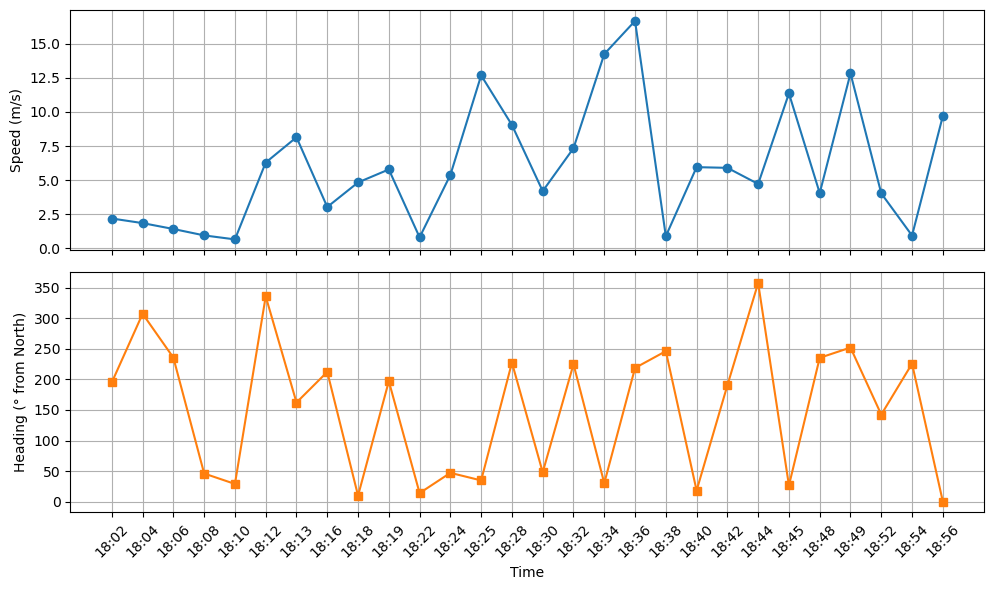

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Haversine formula to compute great-circle distance (in meters)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.deg2rad(lat1), np.deg2rad(lat2)
    dphi = phi2 - phi1
    dlambda = np.deg2rad(lon2 - lon1)

    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # distance in meters

# Sort the timestamps and extract centroids
sorted_times = sorted(fronts_by_time.keys())
centroids = np.array([fronts_by_time[t]['centroid'] for t in sorted_times])
timestamps = np.array(sorted_times)

# Extract lat/lon
longitudes = centroids[:, 0]
latitudes = centroids[:, 1]

speeds = []    # in m/s
headings = []  # in degrees

# Loop through consecutive centroid pairs
for i in range(1, len(centroids)):
    lat1, lon1 = latitudes[i - 1], longitudes[i - 1]
    lat2, lon2 = latitudes[i], longitudes[i]
    t1, t2 = timestamps[i - 1], timestamps[i]

    # Calculate distance and time delta
    dist_m = haversine(lat1, lon1, lat2, lon2)
    dt_s = (t2 - t1).total_seconds()

    # Compute speed (m/s)
    speed = dist_m / dt_s
    speeds.append(speed)

    # Compute compass heading
    dlon = np.deg2rad(lon2 - lon1)
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)

    x = np.sin(dlon) * np.cos(phi2)
    y = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(dlon)
    theta = np.arctan2(x, y)
    heading = (np.degrees(theta) + 360) % 360
    headings.append(heading)

# Optional: convert timestamps to datetime strings for plotting
time_labels = [t.strftime('%H:%M') for t in timestamps[1:]]

# Plot speed and heading
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(time_labels, speeds, 'o-', label='Speed')
axs[0].set_ylabel('Speed (m/s)')
axs[0].grid(True)

axs[1].plot(time_labels, headings, 's-', color='tab:orange', label='Heading')
axs[1].set_ylabel('Heading (° from North)')
axs[1].set_xlabel('Time')
axs[1].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [57]:
def compute_divergence(u_field, v_field, dx, dy):
    dudx = np.gradient(u_field, dx, axis=1)
    dvdy = np.gradient(v_field, dy, axis=0)
    return dudx + dvdy

/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_15162/2183169826.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


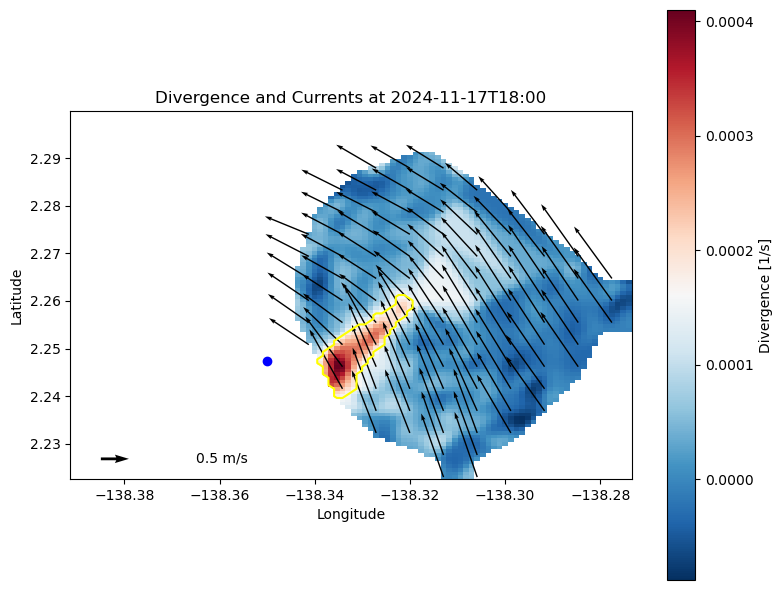

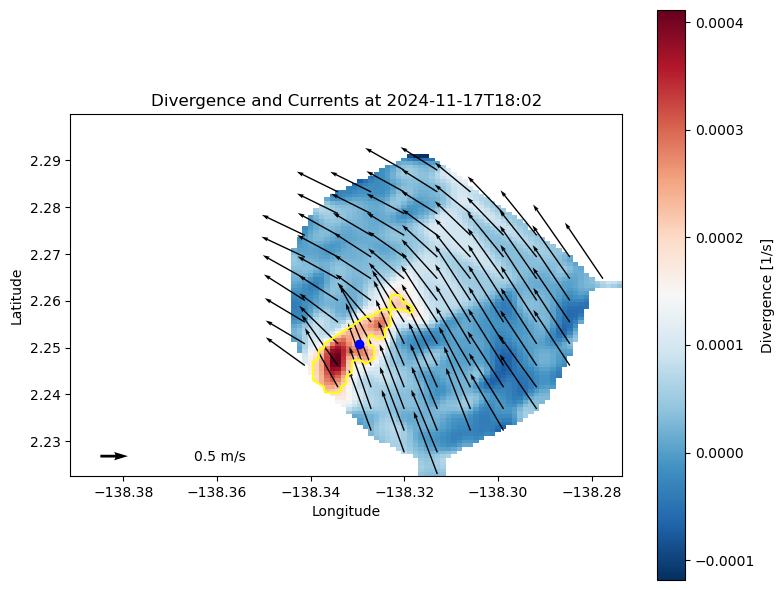

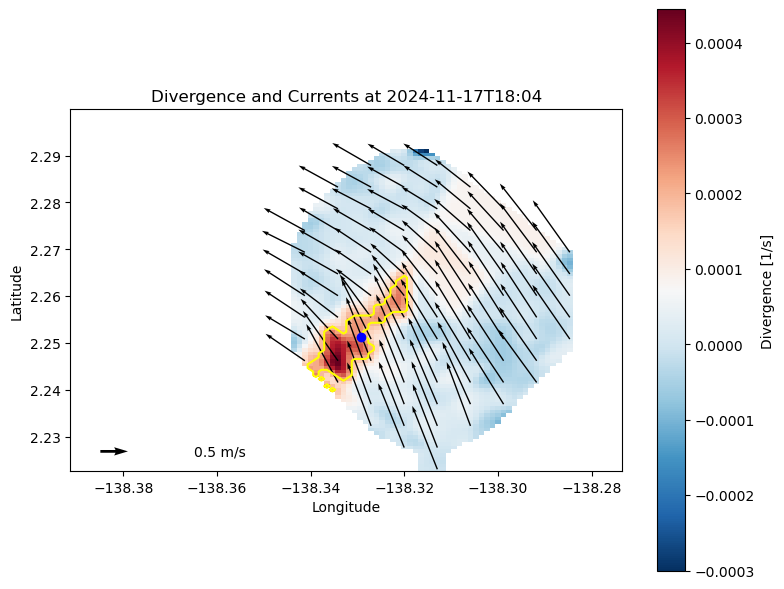

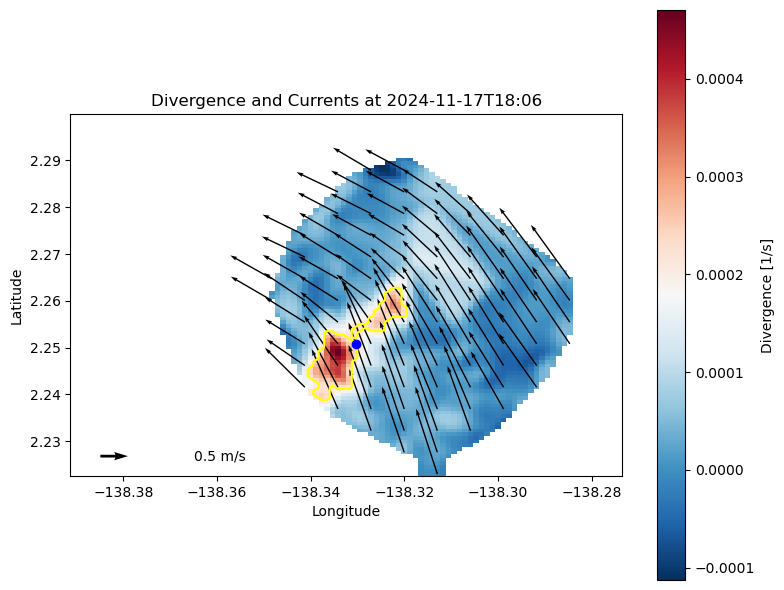

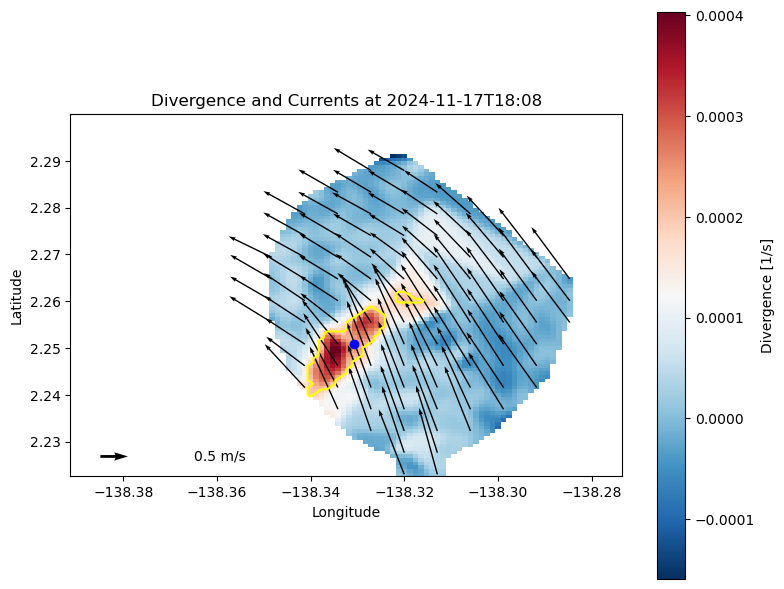

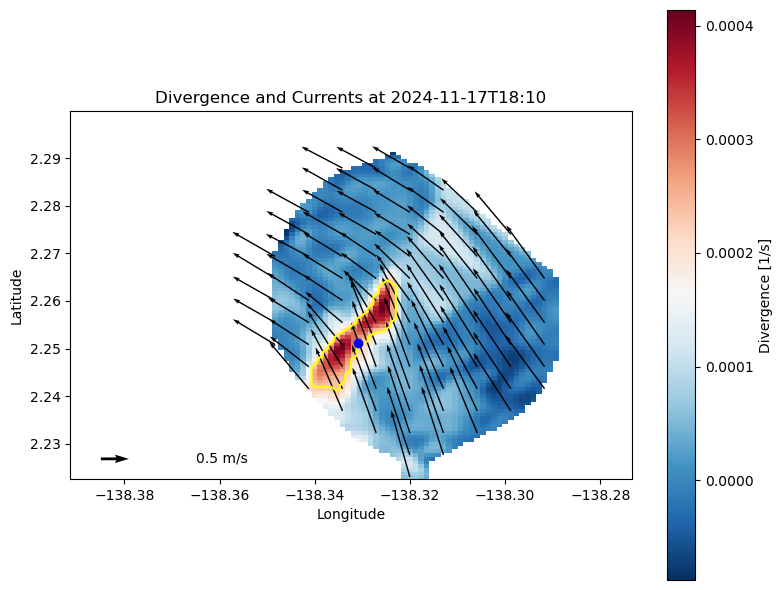

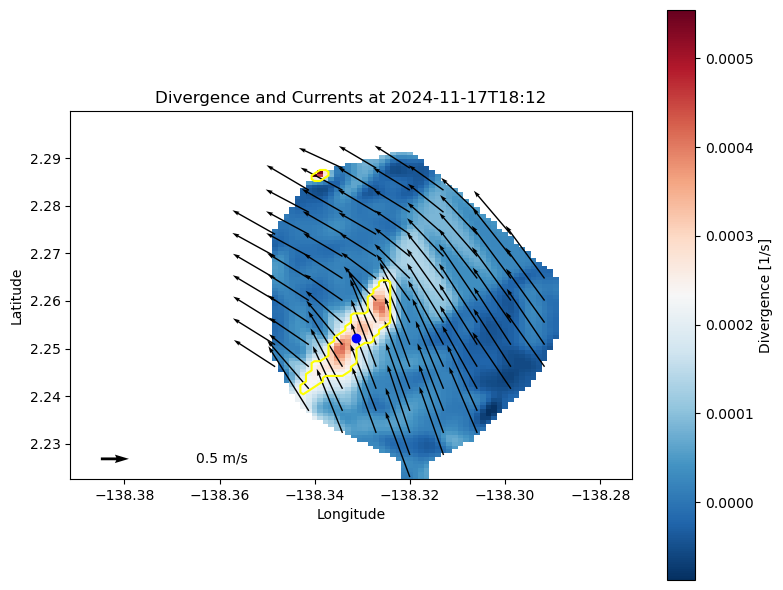

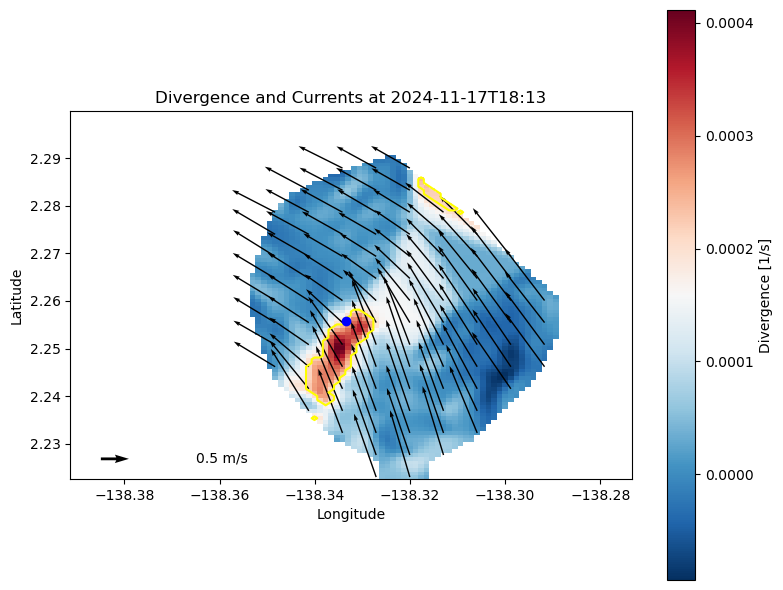

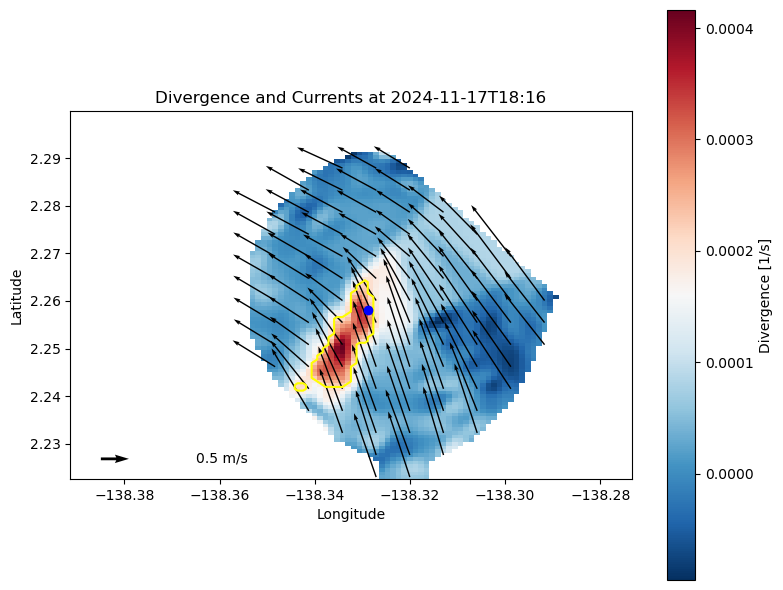

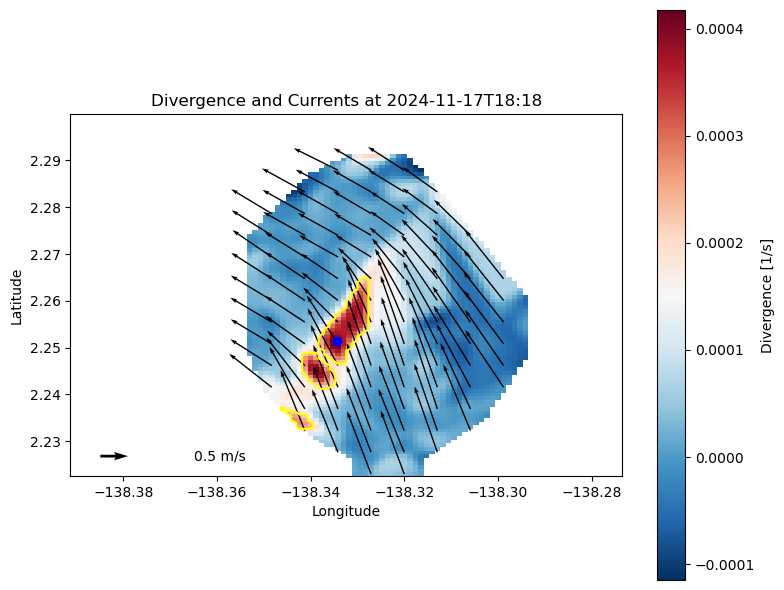

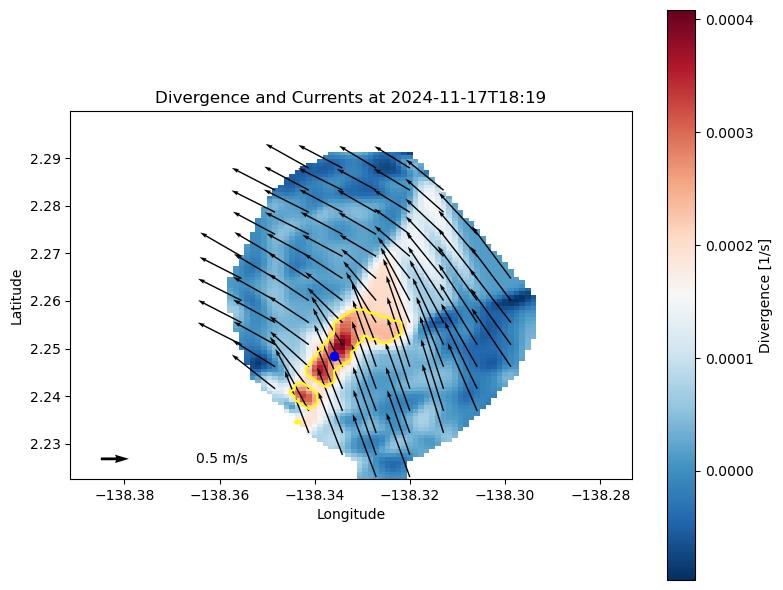

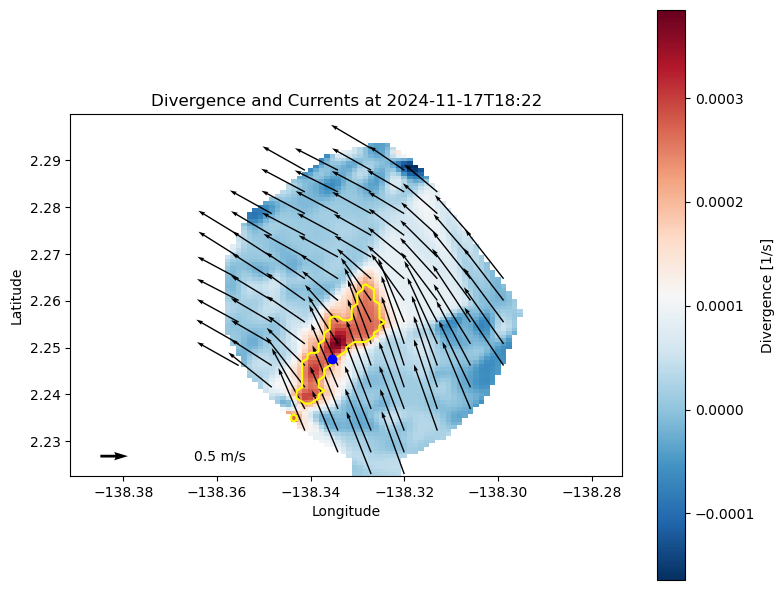

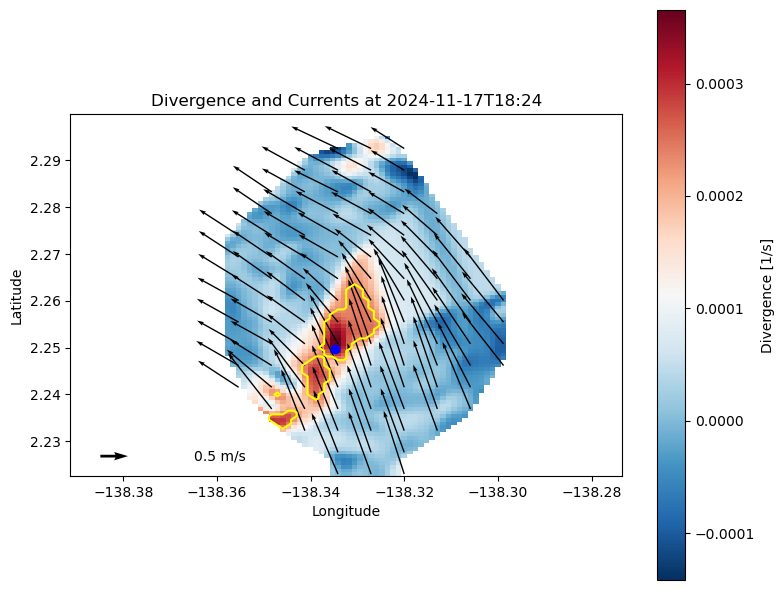

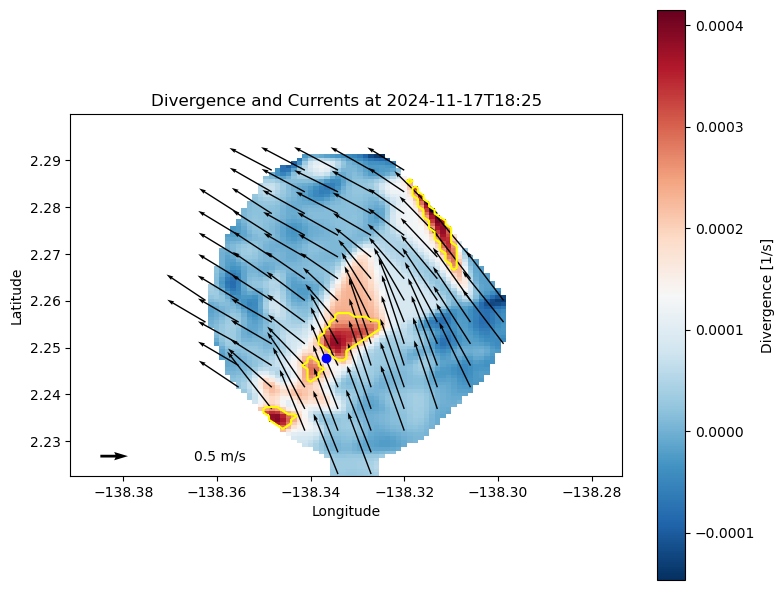

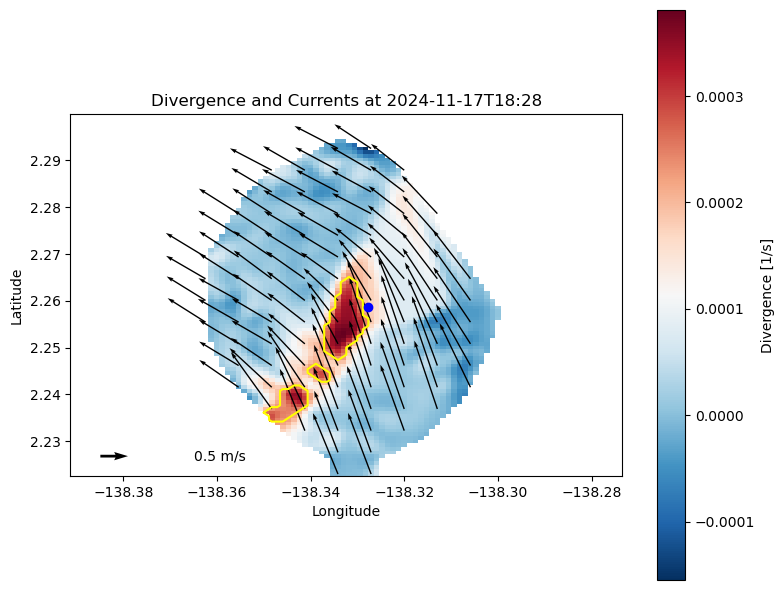

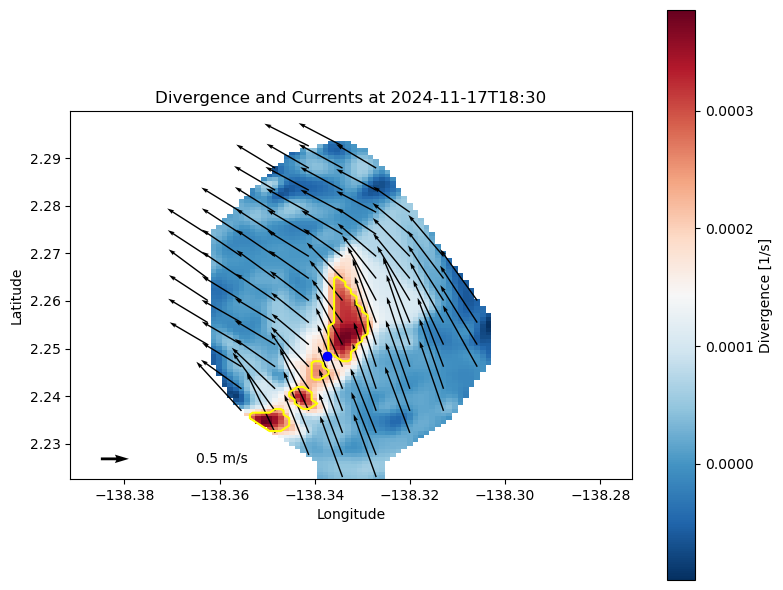

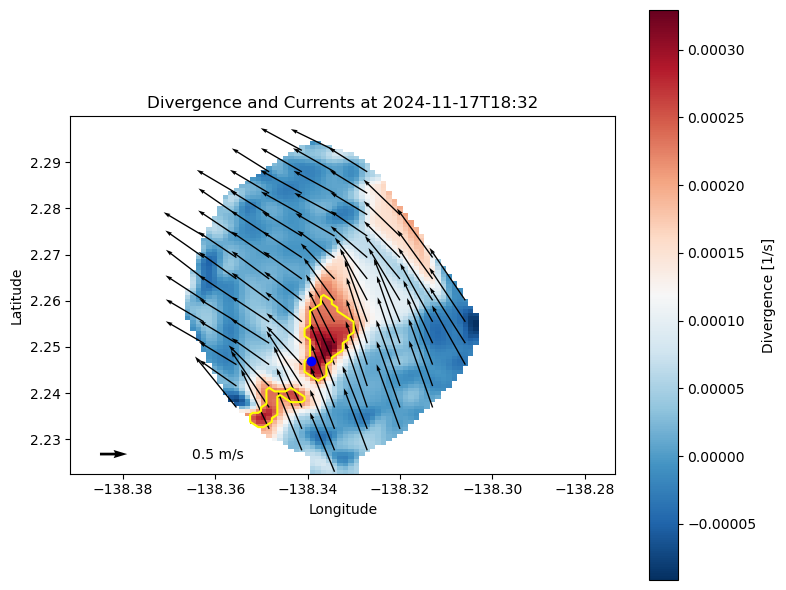

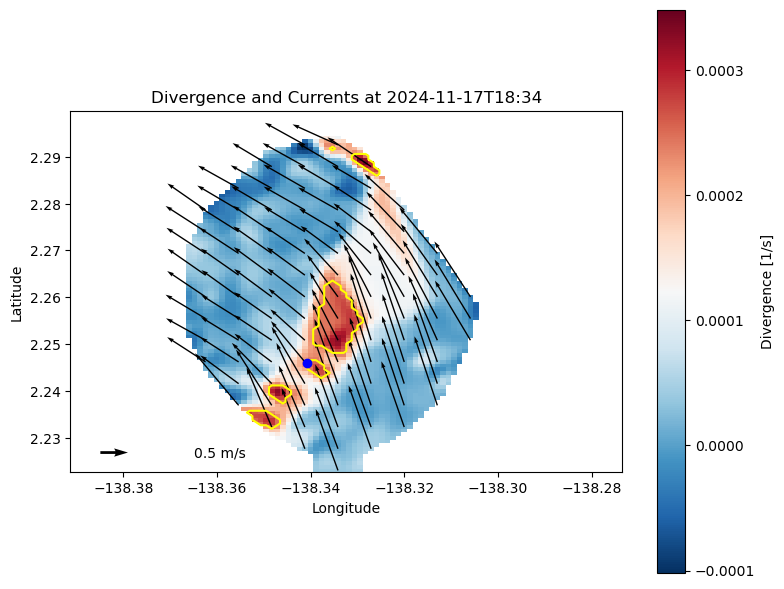

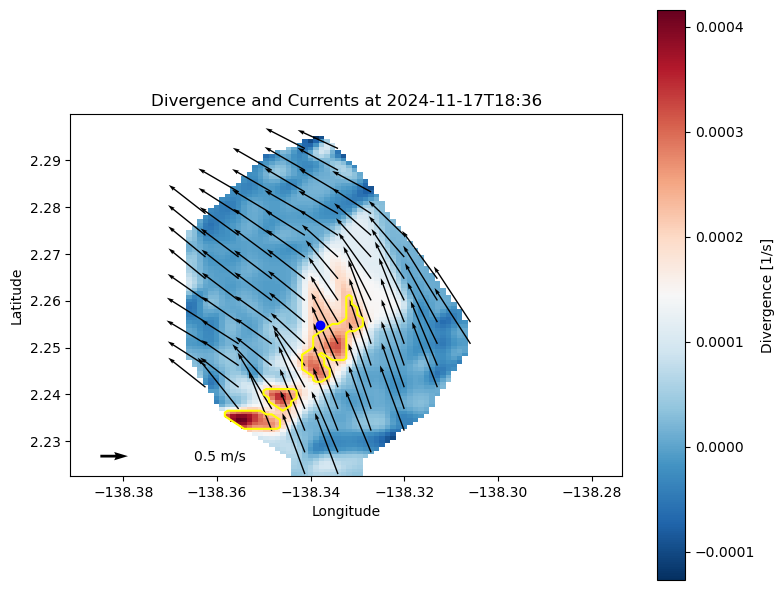

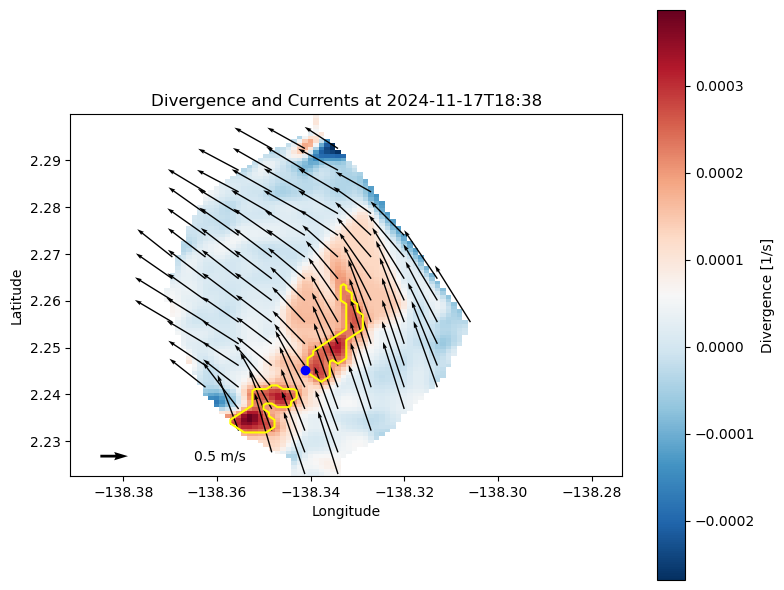

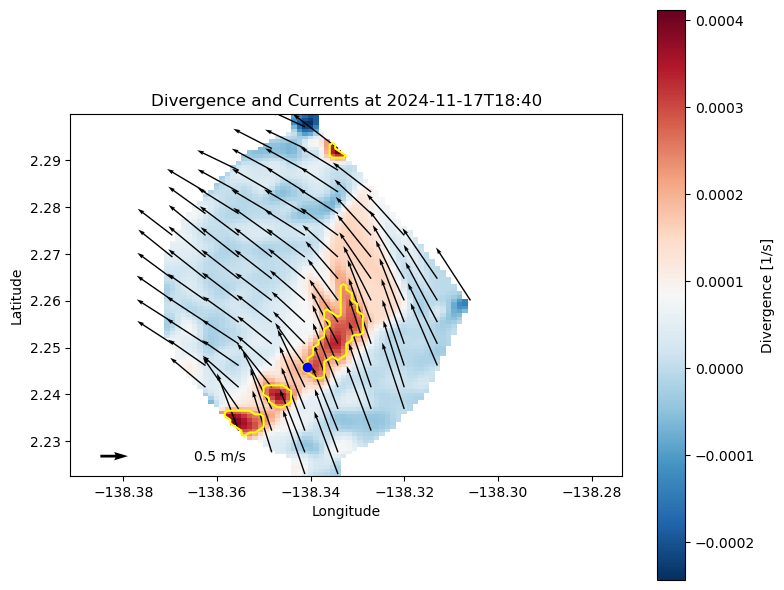

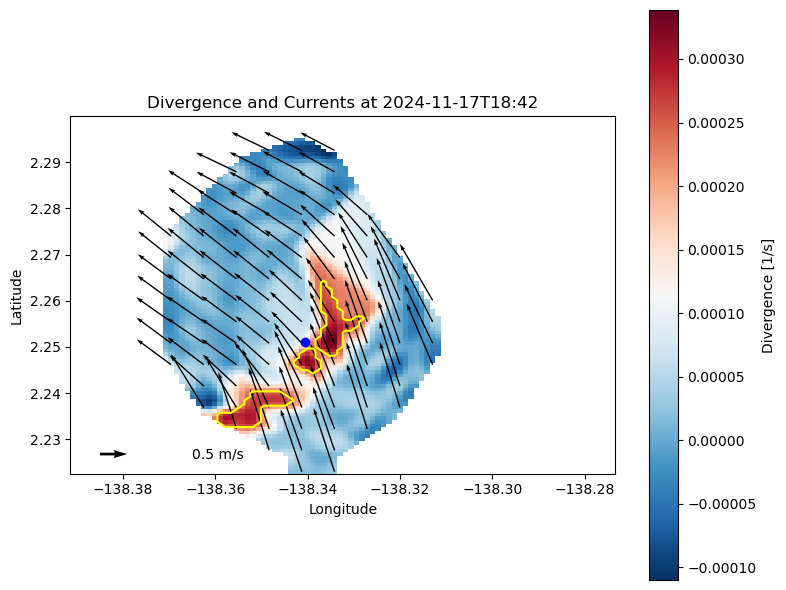

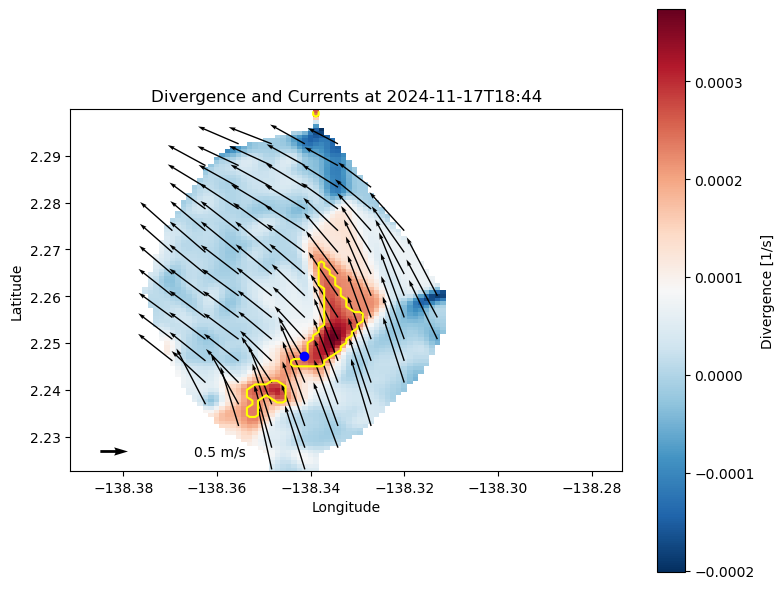

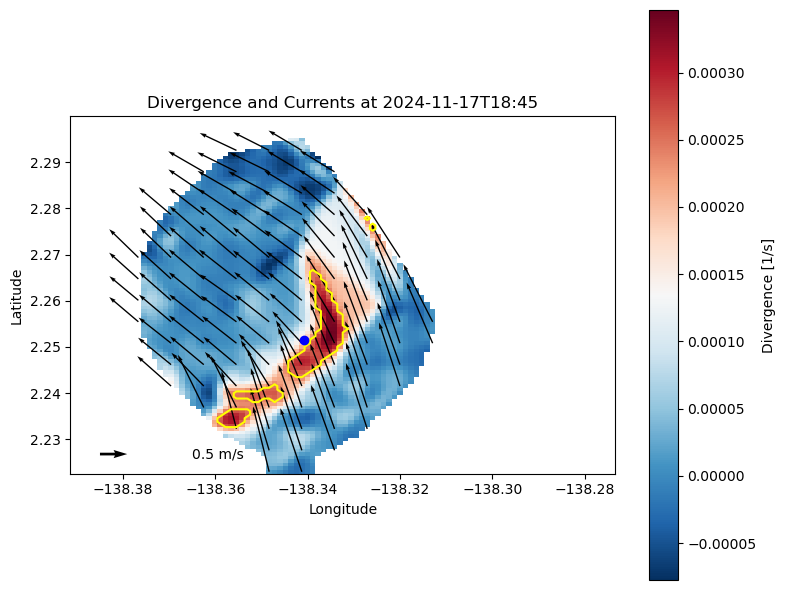

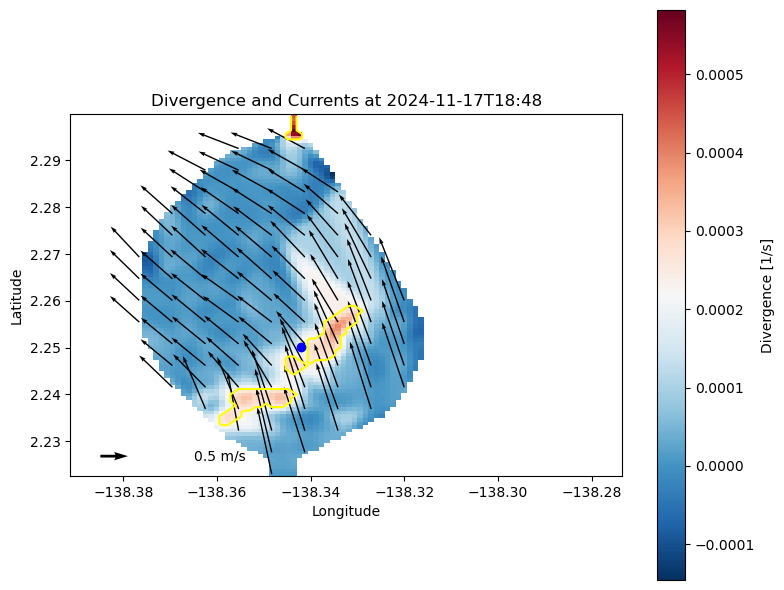

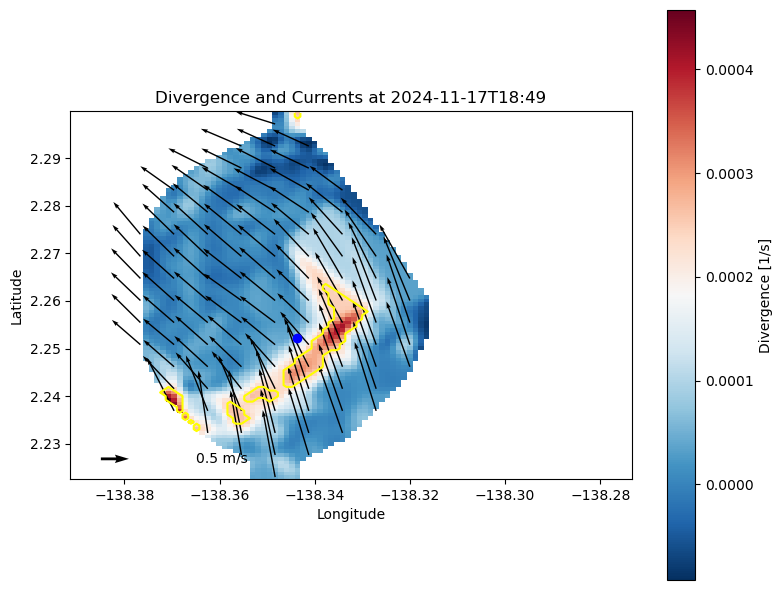

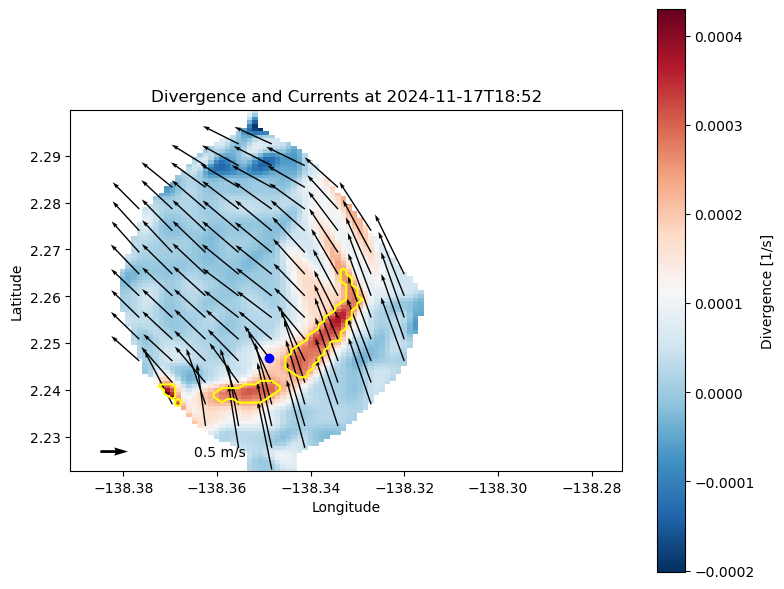

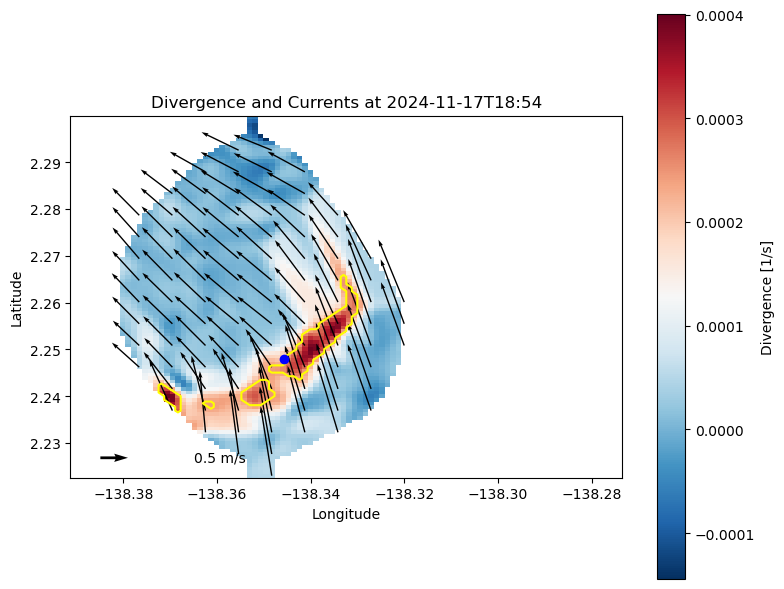

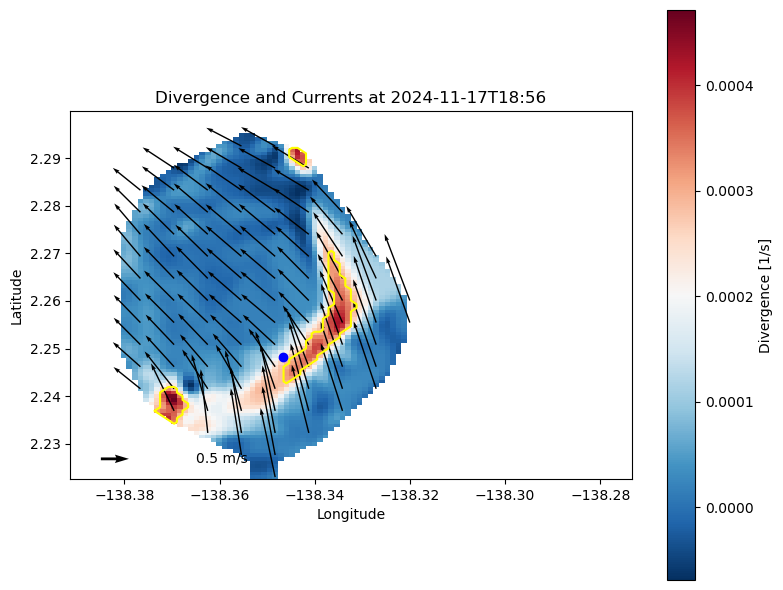

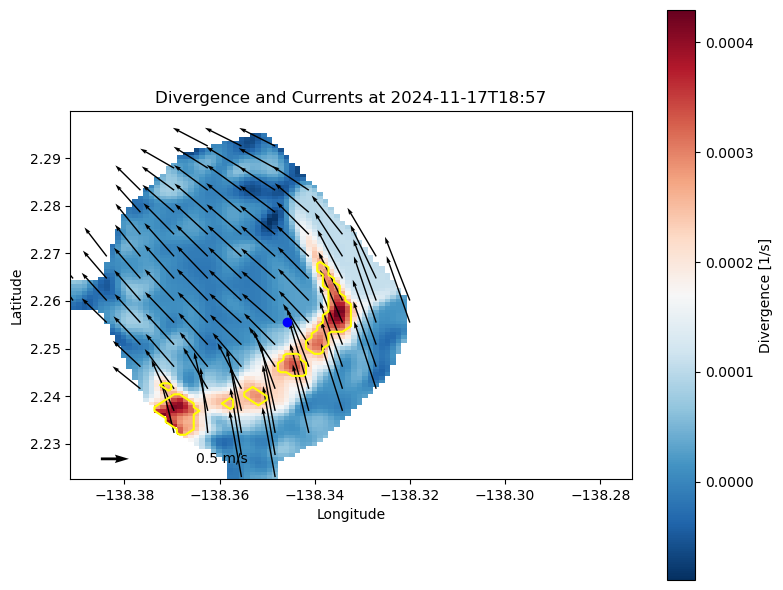

In [76]:
time = np.array(time)  # if not already
if not np.issubdtype(time.dtype, np.datetime64):
    time = np.array([np.datetime64(t) for t in time])

# Define 15-minute bins
start_time = time.min()
end_time = time.max()
time_bins = np.arange(start_time, end_time + np.timedelta64(1, 's'), np.timedelta64(1, 'm'))
time_bins

# Set up lat/lon grid
lat_bins = np.linspace(np.min(lat), np.max(lat), 100)
lon_bins = np.linspace(np.min(lon), np.max(lon), 100)
lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

for i in range(len(time_bins) - 1):
    mask = (time >= time_bins[i]) & (time < time_bins[i+1])
    
    if not np.any(mask):
        continue  # skip empty bins

    # Subset data for this bin
    lat_sub = lat[mask]
    lon_sub = lon[mask]
    u_sub = u[mask]
    v_sub = v[mask]

    # Interpolate u and v onto regular grid
    u_grid = griddata((lat_sub, lon_sub), u_sub, (lat_grid, lon_grid), method='linear')
    v_grid = griddata((lat_sub, lon_sub), v_sub, (lat_grid, lon_grid), method='linear')

    # Optionally smooth data to reduce noise
    u_grid = gaussian_filter(u_grid, sigma=1)
    v_grid = gaussian_filter(v_grid, sigma=1)

    # Speed gradient
    speed = np.sqrt(u_grid**2 + v_grid**2)
    grad_speed = np.sqrt(
        np.gradient(speed, axis=0)**2 +
        np.gradient(speed, axis=1)**2
    )

    # Compute dx and dy in meters using haversine approximation
    dy = 111000 * np.mean(np.gradient(lat_bins))  # approx meters per deg latitude
    dx = 111000 * np.mean(np.gradient(lon_bins)) * np.cos(np.deg2rad(np.mean(lat_bins)))

    # Compute divergence
    divergence = compute_divergence(u_grid, v_grid, dx, dy)

    # Vorticity
    dvdx = np.gradient(v_grid, dx, axis=1)
    dudy = np.gradient(u_grid, dy, axis=0)
    vorticity = dvdx - dudy

    # Q criteria
    dudx = np.gradient(u_grid, dx, axis=1)
    dvdy = np.gradient(v_grid, dy, axis=0)
    shear = (np.gradient(u_grid, dy, axis=0) + np.gradient(v_grid, dx, axis=1)) / 2
    Q = 0.5 * (dudx**2 + dvdy**2 - 2 * shear**2)



    # isolate front-like features
    threshold = np.percentile(vorticity[~np.isnan(vorticity)], 95)
    front_mask = vorticity > threshold

    front_centroids = []
    
    for collection in contour.collections:
        for path in collection.get_paths():
            vertices = path.vertices  # shape (N, 2), columns are lon, lat
            lon_vals, lat_vals = vertices[:, 0], vertices[:, 1]
            if len(vertices) > 3:  # avoid tiny artifacts
                centroid_lon = np.mean(lon_vals)
                centroid_lat = np.mean(lat_vals)
                front_centroids.append((centroid_lon, centroid_lat))



    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot divergence as a colored field
    pcm = ax.pcolormesh(lon_grid, lat_grid, vorticity, cmap='RdBu_r', shading='auto')
    plt.colorbar(pcm, ax=ax, label='Divergence [1/s]')

    contour = ax.contour(lon_grid, lat_grid, front_mask, levels=[0.5], colors='yellow')
    for (centroid_lon, centroid_lat) in front_centroids:
        ax.plot(centroid_lon, centroid_lat, 'bo', markersize=6, label='Front Centroid')


    
    # Downsample the quiver vectors for readability
    stride = 6  # adjust to control spacing
    quiver = ax.quiver(
        lon_grid[::stride, ::stride],
        lat_grid[::stride, ::stride],
        u_grid[::stride, ::stride],
        v_grid[::stride, ::stride],
        scale=5, color='k', width=0.0025
    )
    
    # Add scale arrow
    # Choose a location and a reference vector (e.g., 0.5 m/s)
    scale_arrow_lat = lat_grid.min() + 0.05 * (lat_grid.max() - lat_grid.min())
    scale_arrow_lon = lon_grid.min() + 0.05 * (lon_grid.max() - lon_grid.min())
    ax.quiver(scale_arrow_lon, scale_arrow_lat, 0.5, 0, scale=10, color='k', width=0.005)
    ax.text(scale_arrow_lon + 0.02, scale_arrow_lat, '0.5 m/s', color='k', fontsize=10, va='center')
    
    # Axis labels and title
    ax.set_title(f'Divergence and Currents at {np.datetime_as_string(time_bins[i], unit="m")}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')  # optional, depends on your lat/lon range
    
    plt.tight_layout()
    plt.show()



In [60]:
# what is front_lines

AttributeError: 'list' object has no attribute 'squeeze'

In [62]:
fronts_by_time = {time_bins[i]: front_lines}
fronts_by_time

{numpy.datetime64('2024-11-17T18:57:00.273552000'): [array([[-138.37073374,    2.23497727],
         [-138.37014414,    2.23536364],
         [-138.36955455,    2.23575   ],
         [-138.36896495,    2.23613636],
         [-138.36896495,    2.23690909],
         [-138.36896495,    2.23768182],
         [-138.36896495,    2.23845455],
         [-138.36896495,    2.23922727],
         [-138.36896495,    2.24      ],
         [-138.36896495,    2.24077273],
         [-138.36896495,    2.24154545],
         [-138.36896495,    2.24231818],
         [-138.36955455,    2.24270455],
         [-138.37073374,    2.24270455],
         [-138.37132333,    2.24231818],
         [-138.37132333,    2.24154545],
         [-138.37191293,    2.24115909],
         [-138.37250253,    2.24077273],
         [-138.37250253,    2.24      ],
         [-138.37309212,    2.23961364],
         [-138.37368172,    2.23922727],
         [-138.37427131,    2.23884091],
         [-138.37486091,    2.23845455],
      

In [15]:
time

<xarray.DataArray 'time' (measurement: 5736)> Size: 46kB
array(['2024-11-14T13:00:00.365217000', '2024-11-14T13:00:00.365217000',
       '2024-11-14T13:00:00.365217000', ..., '2024-11-14T13:58:00.063163000',
       '2024-11-14T13:58:00.063163000', '2024-11-14T13:58:00.063163000'],
      dtype='datetime64[ns]')
Coordinates:
  * measurement  (measurement) int64 46kB 0 1 2 3 4 ... 5731 5732 5733 5734 5735
Attributes:
    long_name:      start time of current measurement
    standard_name:  time